Building a Better Board Game
================

## Setup
### Import Libraries

In [1]:
import warnings
import numpy as np
import pandas as pd

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib

print("Matplotlib version {} is installed.").format(matplotlib.__version__)

# Style 'ggplot' makes prettier plots.
# (plt.style isn't supported before matplotlib v1.4)
# Comment the following line, and this notebook will
# still run on matplotlib <1.4, but with default plot styling.
plt.style.use('ggplot')

Matplotlib version 1.5.1 is installed.


### Set some global variables for this notebook

In [2]:
# Set this to the number of CPUs you're comfortable
# having this notebook use during model creation.
cpus = 3

# This is used throughout the notebook for consistent results.
seed = 12

## Data Exploration / Data Preprocessing

Read all of our data in as a pandas data frame

In [3]:
all_data = pd.read_csv("../Data/CSV/games.csv")

How many observations (games) are in our set?

In [4]:
print("The data set contains {} games.").format(len(all_data))

The data set contains 84593 games.


Get an idea of the range of values for each feature in the data

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    print(all_data.describe())

                  id          year   ratingScore   ratingCount  ratingStdDev  \
count   84593.000000  84593.000000  84593.000000  84593.000000  84593.000000   
mean    80013.233152   1807.385008      4.279174    110.736988      0.774242   
std     63960.226532    588.475029      3.039157    929.482652      0.814887   
min         1.000000  -3500.000000      0.000000      0.000000      0.000000   
25%     23001.000000   1985.000000      0.000000      0.000000      0.000000   
50%     60049.000000   2004.000000      5.333330      2.000000      0.695211   
75%    139950.000000   2011.000000      6.716100     15.000000      1.419710   
max    202858.000000   2018.000000     10.000000  59423.000000      4.500000   

          weightAvg  weightLightPct  weightMediumLightPct  weightMediumPct  \
count  84593.000000    71714.000000          71714.000000     71714.000000   
mean       0.876848       19.957703             16.550744        10.183793   
std        1.160127       35.385330          

It seems that most features have values for most games, with the exception of priceAverage and priceStdDev.

In [6]:
feature = "priceAverage"
percentage = len(all_data[feature].dropna())/float(len(all_data)) * 100
print("{:.3f}% of games have a value for the '{}' feature.").format(percentage, feature)

23.005% of games have a value for the 'priceAverage' feature.


How many games have values for *all* features in the set?

In [7]:
all_without_na = all_data.dropna()
percentage = len(all_without_na)/float(len(all_data)) * 100
print("{:.3f}% of games have a values for all features.").format(percentage, feature)
print("{} games remain once filtering out those with null feature values.").format(len(all_without_na))

22.573% of games have a values for all features.
19095 games remain once filtering out those with null feature values.


Some games have feature values that we might choose to consider as outliers.

In [8]:
all_without_na.year.describe()

count    19095.000000
mean      1980.718408
std        209.432133
min      -3500.000000
25%       1994.000000
50%       2006.000000
75%       2012.000000
max       2016.000000
Name: year, dtype: float64

As you can see above, some games were published as early as 3500 B.C.
Perhaps we should limit the year of publication to exclude ancient Egyptian games.

In [9]:
since_1950 = all_without_na.query("year >= 1950")
print("{} games remain once filtering out those published prior to 1950.").format(len(since_1950))

18799 games remain once filtering out those published prior to 1950.


Ratings are crowd-sourced. Ratings may be less reliable if there were too few people contributing to the rating.

How many games have at least three votes cast toward their rating?

In [10]:
at_least_three_raters = since_1950.query("ratingCount >= 5")
print("{} games remain once filtering out those rated by fewer than 5 people").format(len(at_least_three_raters))

17622 games remain once filtering out those rated by fewer than 5 people


Our target variable is going to be 'ratingScore'.

Let's see how the ratingScore value is distributed.

In [11]:
df = at_least_three_raters
df.ratingScore.describe()

count    17622.000000
mean         6.511106
std          0.999621
min          1.500000
25%          5.875985
50%          6.554890
75%          7.221110
max          9.764290
Name: ratingScore, dtype: float64

It seems as if 1.0 is the minimum allowable score, and 10.0 is the max.

A histogram will probably help us see how these ratings are distributed.

## Exploratory Visualization

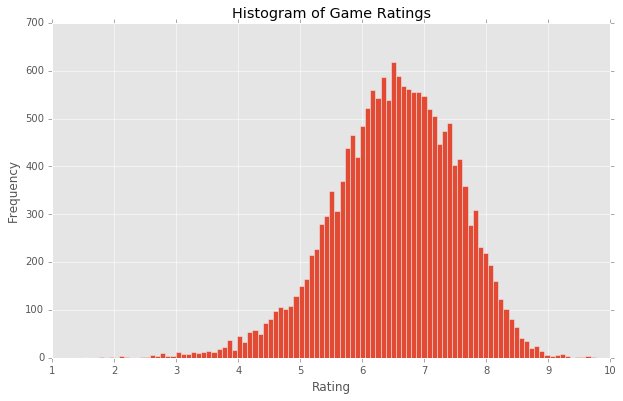

In [12]:
plt.figure(figsize=(10,6))
plt.hist(df.ratingScore, 100)
plt.xlim(xmin=1, xmax=10)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Game Ratings")
plt.show()

Well, that looks like a skewed Gaussian distribution. Ratings of 1.0 and 10.0 are quite uncommon.

The mean of our subset of the data is shifted toward higher ratings.

In [13]:
print "The mean rating for our subset of games is {:.3f}.".format(np.mean(df.ratingScore))

The mean rating for our subset of games is 6.511.


Now let's separate the columns that we intend to use as features from that which is the target.

In [14]:
# Why are we excluding features?
# 'id' holds no predictive value
# 'name', and 'url' are strings, and cannot be features in their current form
# 'ratingCount' and 'ratingStdDev' will likely be unavailable features during prediction
# 'ratingScore' is the target variable, and should not be used to train a model
excluded = ["id", "name", "url", "ratingScore", "ratingCount", "ratingStdDev"]
feature_cols = [col for col in df.columns if col not in excluded]

# This is our target
target_col = "ratingScore"

# Create an n*m data frame where n is the number of games, and m is the number of features
X_all = df[feature_cols]
# Create an n*1 data frame where n is the number of games, each with the single target feature
y_all = df[target_col]

## Implementation

We need to split this data into (at least) two portions.
* A training set - 80% of total
 * We will use 5-fold cross-validation to get predictions on this portion.
* A held-out test (or validation) set - 20% of total
 * We will use this set to prove the performance of the final model.

In [15]:
# Select features (X) and corresponding labels (y) for the trainingCV and holdout sets
# train_test_split() shuffles data randomly. We will set the random state for consistency
from sklearn.cross_validation import train_test_split
# X/y_train are 80% of data, for use in training/testing models.
# X/y_holdout are 20% of data, for use in proving model performance at the end.
X_train, X_holdout, y_train, y_holdout = train_test_split(
    np.array(X_all), np.array(y_all),
    train_size=0.8,
    random_state=seed)

from sklearn.cross_validation import KFold
# We will split X_train into train and test 5 times via KFold
kf = KFold(X_train.shape[0], n_folds=5, shuffle=True, random_state=seed)

print "Cross-validated Training set includes {} samples".format(len(X_train))
print "Holdout/Validation set includes       {} samples".format(len(X_holdout))

Cross-validated Training set includes 14097 samples
Holdout/Validation set includes       3525 samples


With random sampling, we would anticipate the histogram of the target variable in the training and test sets to be similarly distributed.

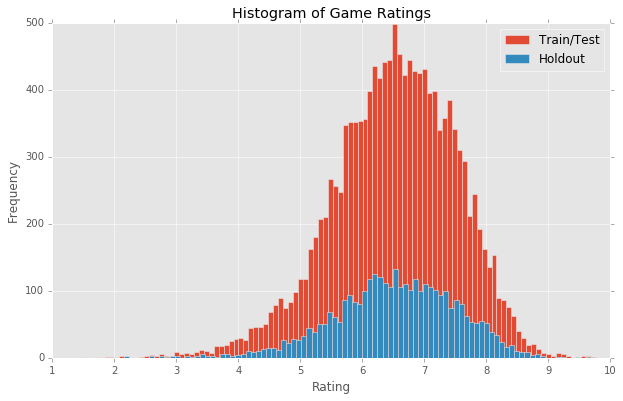

In [16]:
plt.figure(figsize=(10,6))
plt.hist(y_train, 100, label="Train/Test")
plt.hist(y_holdout, 100, label="Holdout")
plt.legend(loc='upper right')
plt.xlim(xmin=1, xmax=10)
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.title("Histogram of Game Ratings")
plt.show()

It's useful to time training jobs. Let's set up some train and predict wrapper functions to do so.

In [17]:
# Helper functions to train and predict
import time

def train(learner, X_train, y_train):
    print "Training {}...".format(learner.__class__.__name__)
    start = time.time()
    learner.fit(X_train, y_train)
    end = time.time()
    print "Done.\nTraining time (secs): {:.3f}".format(end - start)
    
def predict(learner, features):
    print "Predicting target using {}...".format(learner.__class__.__name__)
    start = time.time()
    y_pred = learner.predict(features)
    end = time.time()
    print "Done.\nPrediction time (secs): {:.3f}".format(end - start)
    return pd.Series(y_pred)

### Random Forest regressor
#### A tree-based learner

The first child learner we wish to try is Random Forest. Since there are some parameters that might need to be tuned, we'll make use of GridSearchCV to learn what the best choices for those parameters might be.

In [18]:
# Random Forest is a tree-based learner.
from sklearn.ensemble import RandomForestRegressor
random_forest_reg = RandomForestRegressor(
    n_estimators=2000,  # More is better (but slower)
    oob_score=True,     # 
    random_state=seed)

# We'll mess with some parameters in our grid search.
# A smart choice for max_features is sqrt(num_features).
# For our 159 features, that would be 12.6, so I'm starting in that range.
parameters = {
    'max_features': [10,20,30,40,50,60,80],
    'min_samples_split': [2,3,4,6]
}

# We'll need these to do a grid search.
from sklearn.metrics import make_scorer
from sklearn.grid_search import GridSearchCV

# We'll use MSE as our function to determine the winner in the grid search
from sklearn.metrics import mean_squared_error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up the grid search, using training data in 5 folds
rf_grid = GridSearchCV(random_forest_reg, parameters, scoring=mse_scorer, cv=kf, n_jobs=cpus)

Perform the grid search.

In [19]:
# Fit model to training data - this will take a while.
train(rf_grid, X_train, y_train)
# Let's print which parameter(s) were chosen as the best in the grid
print "\nBest model: {}".format(rf_grid.best_estimator_)

Training GridSearchCV...
Done.
Training time (secs): 6991.263

Best model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=40, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=1, oob_score=True, random_state=12,
           verbose=0, warm_start=False)


It might help to visualize the value from the scorer function across the parameter grid.

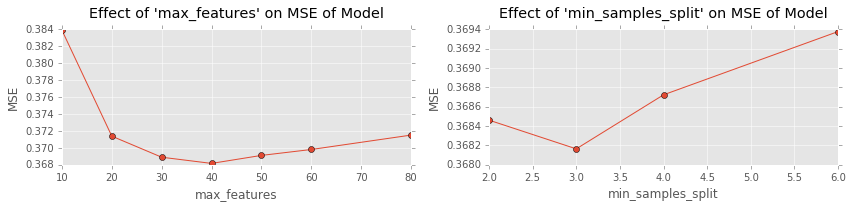

In [20]:
# Subset the grid_scores_ list to isolate one dependent variable
f, (max_features, min_samples_split) = plt.subplots(1, 2, figsize=(12, 3))

# First plot 'max_features'
models = zip(*[(abs(mean), std, p['max_features']) 
    for p, mean, std in [x for x in rf_grid.grid_scores_ if x[0]['min_samples_split'] == 3]])
max_features.plot(models[2],models[0],'o-')
max_features.set_title("Effect of 'max_features' on MSE of Model", y=1.05)
max_features.set_xlabel("max_features")
max_features.set_ylabel("MSE")

# then plot 'min_samples_split'
models = zip(*[(abs(mean), std, p['min_samples_split']) 
    for p, mean, std in [x for x in rf_grid.grid_scores_ if x[0]['max_features'] == 40]])
min_samples_split.plot(models[2],models[0],'o-')
min_samples_split.set_title("Effect of 'min_samples_split' on MSE of Model", y=1.05)
min_samples_split.set_xlabel("min_samples_split")
min_samples_split.set_ylabel("MSE")
f.tight_layout(h_pad=10.05)
plt.show()

* 'max_features' seems to produce a models with the lowest mean squared error around 40 features.
* 'min_samples_split' clearly seems to perform best with a value of 3.

Get Random Forest predictions on all the training data now that we've determined good parameter values.

This is scoring the training set in 5 folds, and collecting the predictions from the held out portion at each fold, to ensure no bias in predictions on the training set.

In [21]:
from sklearn.cross_validation import cross_val_predict
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# Helper utility to show cross-validated performance statistics on a training set.
def show_training_performance(estimator, X, y, cv=5):
    # Compute predictions on the entire set by
    # collecting the predictions on the held-out set from each fold
    y_pred = cross_val_predict(estimator, X, y, cv=cv)
    print "Mean Squared Error:  {}".format(mean_squared_error(y, y_pred))
    print "Pearson Correlation: {}".format(pearsonr(y, y_pred)[0])
    return y_pred

For the metrics we've decided to use for model comparison, how does this model perform?

In [22]:
y_rf_pred = show_training_performance(rf_grid.best_estimator_, X_train, y_train, cv=kf)

Mean Squared Error:  0.3681646466
Pearson Correlation: 0.79626430548


Then let's visualize the actual vs predicted ratingScore, to see how close to the diagonal they are.

In [23]:
# Helper utility to create actual vs. predicted plots
def plot_actual_v_predicted(title, actual, predicted):
    plt.figure(figsize=(6,6))
    plt.plot(actual, predicted, 'o')
    plt.plot([1, 10], [1, 10], 'k--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title("Actual vs. Predicted values for ratingScore - {}".format(title), y=1.05)
    plt.xlim(1, 10)
    plt.ylim(1, 10)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

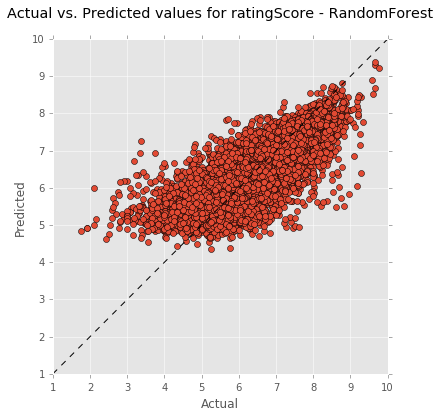

In [24]:
plot_actual_v_predicted("RandomForest", y_train, y_rf_pred)

This model seems hesitant to predict values below 4. The largest errors are thus on the lowest-scoring games.

Now that we've determined good parameter values, let's store them for later use.

In [25]:
# Lock in our best-performing parameters for this estimator
random_forest_reg.set_params(**rf_grid.best_params_)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=40, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=2000, n_jobs=1, oob_score=True, random_state=12,
           verbose=0, warm_start=False)

### K-Nearest-Neighbors
#### An incredibly simple distance-based 'learner'

In [26]:
from sklearn.neighbors import KNeighborsRegressor
k_neighbors_reg = KNeighborsRegressor( weights='distance' )
# We'll mess with some parameters in our grid search.
# n_neighbors is now many neighbors to consider for each point
parameters = {
    'n_neighbors': np.arange(2,32,2)
}
# Set up the grid search, using "base" data in 10 folds
knn_grid = GridSearchCV(k_neighbors_reg, parameters, scoring=mse_scorer, cv=kf, n_jobs=cpus)

What were the best values for the hyper-parameter(s) within our grid?

In [27]:
# KNN models use Euclidian distance, so relative scales of features matter.
# Here we are standardizing the feature values.
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_all)
X_train_scaled = scaler.transform(X_train)
# Fit model to training data
train(knn_grid, X_train_scaled, y_train)
# Let's print which parameter(s) were chosen as the best in the grid
print "\nBest model: {}".format(knn_grid.best_estimator_)

Training GridSearchCV...
Done.
Training time (secs): 346.834

Best model: KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')


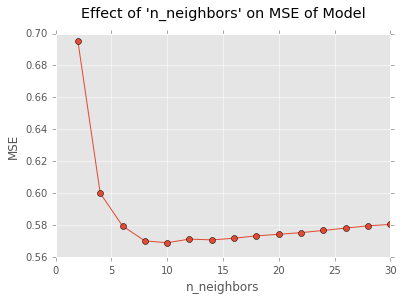

In [28]:
# Plot MSE vs 'n_neighbors'
models = zip(*[(abs(mean), std, p['n_neighbors']) 
    for p, mean, std in [x for x in knn_grid.grid_scores_]])
plt.plot(models[2],models[0],'o-')
plt.title("Effect of 'n_neighbors' on MSE of Model", y=1.05)
plt.xlabel("n_neighbors")
plt.ylabel("MSE")
plt.show()

* n_neighbors had an clear impact the resulting model's mean squared error. **10 Seemed to be a good value** (though not by much)

Get K Neighbor predictions on all the training data now that we've determined good parameter values.

Mean Squared Error:  0.568845614465
Pearson Correlation: 0.660520144685


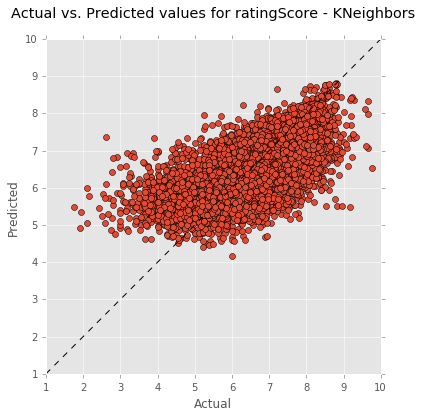

In [29]:
y_knn_pred = show_training_performance(knn_grid.best_estimator_, X_train_scaled, y_train, cv=kf)
plot_actual_v_predicted("KNeighbors", y_train, y_knn_pred)

Interestingly, this model _does_ predict values below 4 at times, though only when the games scored above a 4.

In [30]:
# Lock in our best-performing parameters for this estimator
k_neighbors_reg.set_params(**knn_grid.best_params_)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')

### Support Vector regressor
#### A slow learner, with many important (and dependent) parameters

I initially attempted to test multiple paramters in this grid. After **9 days**, modeling had not finished. I was eventually forced to try small sets of parameters and values so that I could achieve results at all.

 - I first varied the value of 'C', before settling on a best value of 10.
 - Then I varied the value of 'gamma', with 'C' fixed, and settled on a value of 0.001.

I am aware that this is not an ideal method, as these two parameters are likely dependent, and if I had time for a more exhaustive grid search, the winning pair of these features might indeed be different for this feature set.

In [31]:
# The Support Vector Machine (SVM) as a regression is referred to as SVR.
from sklearn.svm import SVR
support_vector_reg = SVR()
# We'll mess with some parameters in our grid search.
# C - Penalty parameter (1/lambda)
# kernel - method of mapping multi-dimensional feature space into lower dimensions to fit a plane
parameters = {
    'C':      [1,10,100],  # Determined through prior grid searches on only this parameter
    'gamma':  [0.0001,0.001,0.01],   # Subsequent single-parameter grid search
}
# Set up the GridSearch with cross-validation
svr_grid = GridSearchCV(support_vector_reg, parameters, scoring=mse_scorer, cv=kf, n_jobs=cpus)

In [32]:
# Fit model to training data (with standardized data)
train(svr_grid, X_train_scaled, y_train)
# Let's print which parameter(s) were chosen as the best in the grid
print "Best model: {}".format(svr_grid.best_estimator_)

Training GridSearchCV...
Done.
Training time (secs): 1673.969
Best model: SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


What were the best values for the hyper-parameter(s) within our grid?

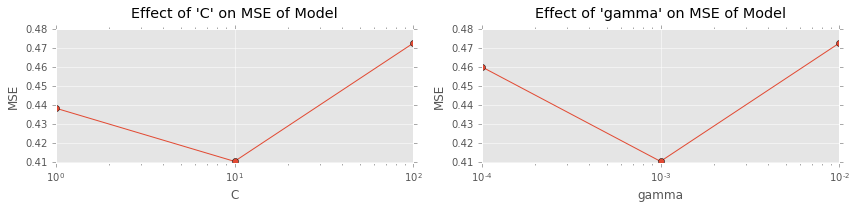

In [33]:
# Subset the grid_scores_ list to isolate one dependent variable
f, (c, gamma) = plt.subplots(1, 2, figsize=(12, 3))

# First plot 'max_features'
models = zip(*[(abs(mean), std, p['C']) 
    for p, mean, std in [x for x in svr_grid.grid_scores_ if x[0]['gamma'] == 0.001]])
c.plot(models[2],models[0],'o-')
c.set_title("Effect of 'C' on MSE of Model", y=1.05)
c.set_xlabel("C")
c.set_xscale("log")
c.set_ylabel("MSE")

# then plot 'min_samples_split'
models = zip(*[(abs(mean), std, p['gamma']) 
    for p, mean, std in [x for x in svr_grid.grid_scores_ if x[0]['C'] == 10]])
gamma.plot(models[2],models[0],'o-')
gamma.set_title("Effect of 'gamma' on MSE of Model", y=1.05)
gamma.set_xlabel("gamma")
gamma.set_xscale("log")
gamma.set_ylabel("MSE")
f.tight_layout(h_pad=10.05)
plt.show()

Let's again visualize the actual vs predicted ratingScore

Mean Squared Error:  0.410589573021
Pearson Correlation: 0.768832708798


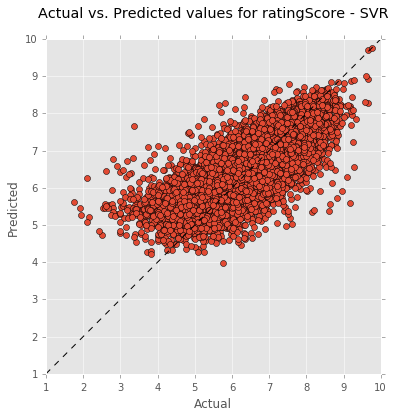

In [34]:
y_svr_pred = show_training_performance(svr_grid.best_estimator_, X_train_scaled, y_train, cv=kf)
plot_actual_v_predicted("SVR", y_train, y_svr_pred)

In [35]:
# Lock in our best-performing parameters for this estimator
support_vector_reg.set_params(**svr_grid.best_params_)

SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.001,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

### Gradient Boosting Regressor
#### Another ensemble model

What if we stacked these two learners together to create another model?

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
gradient_boost_reg = GradientBoostingRegressor(
    max_features=40,    # Choosing (for better or worse) to use the optimal value from the RF gridsearch
    n_estimators=1000,  # More is better (but slower)
    random_state=seed)
# We'll mess with one parameter in our grid search. (GBR takes a long time)
# max_depth - How far to grow each of the trees
parameters = {
    'max_depth': [2, 4, 6, 8, 10, 15, 20],
}
# Set up the GridSearch with cross-validation
gbr_grid = GridSearchCV(gradient_boost_reg, parameters, scoring=mse_scorer, cv=kf, n_jobs=cpus)

What were the best values for the hyper-parameter(s) within our grid?

In [37]:
# Fit model to training data - not nearly as long-running as RandomForest
train(gbr_grid, X_train, y_train)
print "Best model: {}".format(gbr_grid.best_estimator_)

Training GridSearchCV...
Done.
Training time (secs): 2688.459
Best model: GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=40, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=12, subsample=1.0, verbose=0,
             warm_start=False)


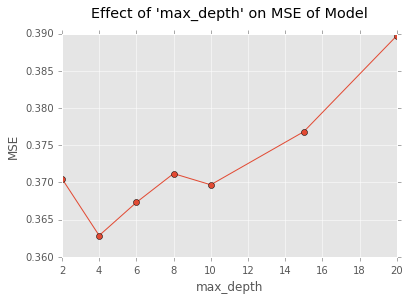

In [38]:
# Plot 'max_depth' vs MSE
models = zip(*[(abs(mean), std, p['max_depth']) for p, mean, std in gbr_grid.grid_scores_])
plt.plot(models[2],models[0],'o-')
plt.title("Effect of 'max_depth' on MSE of Model", y=1.05)
plt.xlabel("max_depth")
plt.ylabel("MSE")
plt.show()

Let's again visualize the actual vs predicted ratingScore

Mean Squared Error:  0.362856147435
Pearson Correlation: 0.798432186811


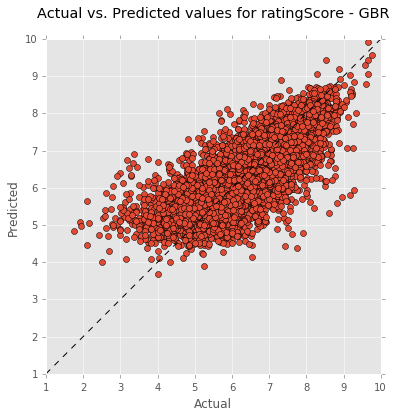

In [39]:
y_gbr_pred = show_training_performance(gbr_grid.best_estimator_, X_train, y_train, cv=kf)
plot_actual_v_predicted("GBR", y_train, y_gbr_pred)

In [40]:
# Lock in our best-performing parameters for this estimator
gradient_boost_reg.set_params(**gbr_grid.best_params_)

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=4, max_features=40, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1000,
             presort='auto', random_state=12, subsample=1.0, verbose=0,
             warm_start=False)

## Creating a Pipeline for Stacking

I couldn't seem to find a standard implementation for this.

It's a bit tedious to train all of the child learners, then stack them manually. Why don't we make an estimator that accepts an array of child estimators, and a meta (stacking) estimator, and does the work for us?

In [41]:
from sklearn.externals.joblib import Parallel, delayed
from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import pearsonr
from sklearn.cross_validation import cross_val_predict

def _fit_estimator(estimator, X, y, scaler=False, cv=10, verbose=0, random_state=None):
    """Private function used to fit with a single estimator in parallel."""
    # If requested for this estimator, scale the features
    if(scaler):
        X = scaler.transform(X)
    # Get cross-validated predictions on all of the data - to feed to stacker    
    y_pred = cross_val_predict(estimator, X, y, cv=10)
    if verbose > 0:
        print "Estimator: {}".format(estimator.__class__.__name__)
        print "  Mean Squared Error:  {}".format(mean_squared_error(y, y_pred))
        print "  Pearson Correlation: {}".format(pearsonr(y, y_pred)[0])
    # Train the final estimator on all data
    estimator.fit(X, y)
    # Return the cross-validated predictions for this child estimator
    return y_pred

def _predict_estimator(estimator, X, scaler=False, verbose=0):
    """Private function used to predict with a single estimator in parallel."""
    # If requested for this estimator, scale the features
    if(scaler):
        X = scaler.transform(X)
    # Return the cross-validated predictions for this child estimator
    return estimator.predict(X)

class StackedRegression:
    
    def __init__(self, estimators, meta_estimator, cv=None, random_state=None, n_jobs=1, verbose=0):
        self.__class__.__name__ = 'StackedRegression'
        self.estimators = estimators
        self.meta_estimator = meta_estimator
        self.cv = cv
        self.random_state = random_state
        self.n_jobs = n_jobs
        self.verbose = verbose
    
    def fit(self, X, y):
        """Fit the model according to the given training data."""
        # Parallel loop: fit each estimator, storing cross-validated predictions
        self.child_predictions_ = np.transpose(np.array(
            Parallel(n_jobs=self.n_jobs, verbose=self.verbose, backend="threading")(
                delayed(_fit_estimator)(
                    est['estimator'], X, y, scaler=est['scaler'] if 'scaler' in est else False, cv=self.cv,
                    verbose=self.verbose, random_state=self.random_state)
                for est in self.estimators)))
        # fit the meta-estimator on the predictions from the child estimators
        self.stack_pred_ = _fit_estimator(self.meta_estimator['estimator'],
            self.child_predictions_, y, scaler=False,
            cv=self.cv, verbose=self.verbose, random_state=self.random_state)
        return self
    
    def predict(self, X):
        """Predict class for X."""
        # First predict with all child estimators
        # Parallel loop: predict with each child estimator
        child_predictions = np.transpose(np.array(
            Parallel(n_jobs=self.n_jobs, verbose=self.verbose, backend="threading")(
                delayed(_predict_estimator)(est['estimator'], X, scaler=est['scaler'] if 'scaler' in est else False,
                                            verbose=self.verbose)
                for est in self.estimators)))
        # fit the meta-estimator on the predictions from the child estimators
        stack_predictions = _predict_estimator(self.meta_estimator['estimator'], child_predictions,
                                               scaler=False,
                                               verbose=self.verbose)
        return stack_predictions

Now let's instantiate a meta-estimator, and the StackedRegressor.

We'll be stacking the predictions of:
 * Random Forest
 * K-Nearest Neighbors
 * Support Vector Regression
 * Gradient Boosting Regression

With a meta-estimator (stacker) of:
 * LassoCV - a linear modeler
 
**NOTE**: We stored the best\_params\_ of each grid search above, so each child estimator will only attempt to make one model, with those best parameters this time around.

In [42]:
# I'll use a linear model (Lasso) as the "meta-estimator" or stacker
from sklearn.linear_model import LassoCV
lasso_cv_reg = LassoCV()

# Provide standard scaling for some learners
from sklearn import preprocessing
standard_scaler = preprocessing.StandardScaler().fit(X_all)

# Create the stacking regression learner
stacker = StackedRegression(
    # Child estimators
    [{'estimator': random_forest_reg},
     {'estimator': k_neighbors_reg,    'scaler': standard_scaler},
     {'estimator': support_vector_reg, 'scaler': standard_scaler},
     {'estimator': gradient_boost_reg}],
    # Stacking meta-estimator
    {'estimator': lasso_cv_reg},
    # Additional settings, passed to lower-level estimators
    cv=kf,
    #verbose=1,
    random_state=seed,
    n_jobs=cpus)

Let's give it a whirl!

In [43]:
# Now train it
train(stacker, X_train, y_train)

Training StackedRegression...
Done.
Training time (secs): 2012.814


## Each Estimator's Performance on The Held-out Set

In [83]:
# Show holdout performance
def show_holdout_performance(estimator, X, actual_y):
    # Compute predictions on the held out set
    predicted_y = estimator.predict(X)
    print(estimator.__class__.__name__)
    mse = mean_squared_error(actual_y, predicted_y)
    corr = pearsonr(actual_y, predicted_y)[0]
    print "  Mean Squared Error:  {}".format(mse)
    print "  Pearson Correlation: {}".format(corr)
    return (mse, corr, predicted_y)

# Iterate over each estimator, scale features as necessary, score the held-out set
performance = pd.DataFrame()
for est in ([{'estimator': random_forest_reg},
             {'estimator': k_neighbors_reg,    'scaler': scaler},
             {'estimator': support_vector_reg, 'scaler': scaler},
             {'estimator': gradient_boost_reg}]):
    if('scaler' in est):
        X = est['scaler'].transform(X_holdout)
    else:
        X = X_holdout
    (mse, corr, predictions) = show_holdout_performance(est['estimator'], X, y_holdout)
    performance = performance.append(pd.Series([est['estimator'].__class__.__name__, mse, corr]), ignore_index=True)

RandomForestRegressor
  Mean Squared Error:  0.369919958452
  Pearson Correlation: 0.794390683847
KNeighborsRegressor
  Mean Squared Error:  0.535479812911
  Pearson Correlation: 0.683169963154
SVR
  Mean Squared Error:  0.408616531813
  Pearson Correlation: 0.769350107821
GradientBoostingRegressor
  Mean Squared Error:  0.358261623101
  Pearson Correlation: 0.800556639349


It'd be interesting to note how the linear stacker weighted the importance of each of the child learners.

In [45]:
pd.Series(stacker.meta_estimator['estimator'].coef_,
          index=[e['estimator'].__class__.__name__ for e in stacker.estimators])

RandomForestRegressor        0.450035
KNeighborsRegressor          0.082644
SVR                          0.114073
GradientBoostingRegressor    0.423877
dtype: float64

In [84]:
(mse, corr, final_predictions) = show_holdout_performance(stacker, X_holdout, y_holdout)
performance = performance.append(pd.Series([stacker.__class__.__name__, mse, corr]), ignore_index=True)

StackedRegression
  Mean Squared Error:  0.344842206614
  Pearson Correlation: 0.808836787278


It looks as if we've been able to achieve a higher correlation via stacking than from any learner individually (barely).

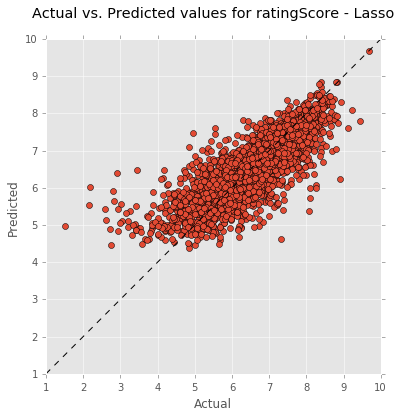

In [60]:
plt.figure(figsize=(6,6))
plt.plot(y_holdout, final_predictions, 'o')
plt.plot([1, 10], [1, 10], 'k--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs. Predicted values for ratingScore - Lasso", y=1.05)
plt.xlim(1, 10)
plt.ylim(1, 10)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## An Attempt at Improvement

With 84593 games, we were forced to shrink our data to 17622 examples to ensure that all features had values.

What if we dropped _priceAverage_, and _priceStdDev_, since the majority of the games did not have values for these features?

This should help to answer which is more important to the creation of a strong model:

 - The inclusion of _priceAverage_ and _priceStdDev_, potentially predictive features
 - The inclusion of more training data to these learners

Repeating the subsetting of data from above, but after removing two columns from the feature vector

In [48]:
# Drop the two price-based features
no_prices = all_data.drop(['priceAverage','priceStdDev'], axis=1)
print("Games initially:    {}").format(len(no_prices))
# Drop all rows with NA in any feature column
no_prices_without_na = no_prices.dropna()
print("Games without NAs:  {}").format(len(no_prices_without_na))
# Filter with the same assumptions as previously
df_no_prices = no_prices_without_na.query("year >= 1950 & ratingCount >= 5")
print("Games after filter: {}").format(len(df_no_prices))

# Split into features and target
excluded = ["id", "name", "url", "ratingScore", "ratingCount", "ratingStdDev"]
feature_cols = [col for col in df_no_prices.columns if col not in excluded]
X_all_no_prices = df_no_prices[feature_cols]
y_all_no_prices = df_no_prices[target_col]

# Again, an 80/20 split, but from a larger data pool
X_train_no_prices, X_holdout_no_prices, y_train_no_prices, y_holdout_no_prices = train_test_split(
    np.array(X_all_no_prices), np.array(y_all_no_prices),
    train_size=0.8,
    random_state=seed)

Games initially:    84593
Games without NAs:  71714
Games after filter: 32240


That's a shame. It seems that the same games that don't have price history information are often the ones with ratings provided by fewer than five raters. I suppose that would make sense, but it also limits our usable data.

Let's produce a plot to see if what we're inferring is correct.

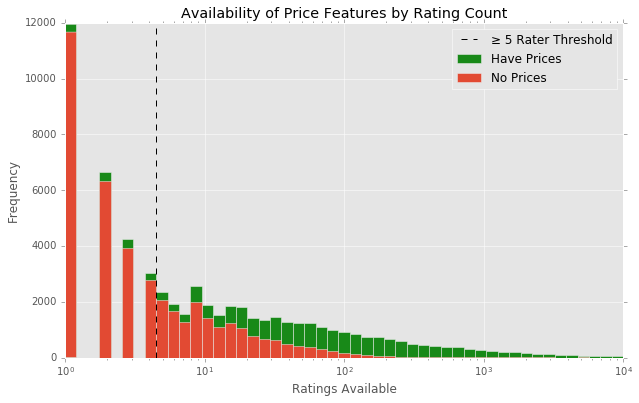

In [49]:
# For Unicode '≥' symbol
from __future__ import unicode_literals

plt.figure(figsize=(10,6))
plt.hist(all_data['ratingCount'],
         bins=np.logspace(0, 4, 50), color="#188918", label="Have Prices")
plt.hist(all_data.query("priceAverage != priceAverage")['ratingCount'],    # See citation
         bins=np.logspace(0, 4, 50), color="#e24a33", label="No Prices")
# Line at the threshold of 5 raters
plt.plot([4.5, 4.5], [0, 12000], 'k--', label="≥ 5 Rater Threshold")
plt.gca().set_xscale('log')
plt.ylabel("Frequency")
plt.xlabel("Ratings Available")
plt.legend(loc='upper right')
plt.title("Availability of Price Features by Rating Count")
plt.show()

# Citation - Hack to use pandas query() to find rows with null value
# http://stackoverflow.com/questions/26535563/querying-for-nan-and-other-names-in-pandas

Yup. The first time around:
 - We removed the observations (i.e games or rows) with no price data - the red portion in the chart.
 - Then we removed the remaining (green) observations with fewer than five raters. This removed a negligible amount of data.

However, the second time around:
 - We left in the observations with price data (red)
 - Then again removed the observations with fewer than five raters (red + green to the left of the threshold), which resulted in a large amount of lost data.

It is pretty clear from this chart that once approximately one-hundred raters have participated, the game is nearly guaranteed to have available price data.

Now we're ready to train the child learners, and the stacker.

**Note:**, I have choosen not to perform a new grid search for new parameter values. This seems a reasonable choice, as the number (and values) of features are nearly the same, and this will save a good deal of time.

In [50]:
# We should re-calculate the standard scaler with this data (it shouldn't differ by much)
standard_scaler_no_prices = preprocessing.StandardScaler().fit(X_all_no_prices)

# So we don't overwrite our models from before.
from sklearn.base import clone

# Create the stacking regression learner
stacker_no_prices = StackedRegression(
    # Child estimators - cloning the previous ones here to not overwrite the original models
    [{'estimator': clone(random_forest_reg)},
     {'estimator': clone(k_neighbors_reg),    'scaler': standard_scaler_no_prices},
     {'estimator': clone(support_vector_reg), 'scaler': standard_scaler_no_prices},
     {'estimator': clone(gradient_boost_reg)}],
    # Stacking meta-estimator
    {'estimator': clone(lasso_cv_reg)},
    # Additional settings, passed to lower-level estimators
    cv=kf,
    #verbose=1,
    random_state=seed,
    n_jobs=cpus)

# Now train it
train(stacker_no_prices, X_train_no_prices, y_train_no_prices)

# How were the child learners weighted?
pd.Series(stacker_no_prices.meta_estimator['estimator'].coef_,
          index=[e['estimator'].__class__.__name__ for e in stacker_no_prices.estimators])

# Predict on the holdout set
final_predictions_no_prices = show_holdout_performance(stacker_no_prices, X_holdout_no_prices, y_holdout_no_prices)

Training StackedRegression...
Done.
Training time (secs): 4513.931
StackedRegression
  Mean Squared Error:  0.557246071492
  Pearson Correlation: 0.765398399292


The correlation of 0.7653 is lower than that of 0.8088 from the model that included price-based features.

**It seems that in this case, price-based features provided more predictive power than nearly doubling the size of the training set.**

## Playing at Board Game Design

Now that we have a model that predicts crowd-sourced game ratings with reasonable accuracy, can we use it to help us design a best-selling game?

Let's explore the 157-dimensional feature space by creating 100,000 reasonable feature vectors, creating predicted ratings for each, and evaluating the vectors that score well.

In [51]:
# We want to get consistent results
np.random.seed(seed=seed)
# Number of proposed game feature vectors to create
games_to_create = 100000

# Pre-allocate a pandas DataFrame of n x m (games_to_create observations, by 157 features)
excluded = ["id", "name", "url", "ratingScore", "ratingCount", "ratingStdDev"]
feature_cols = [col for col in all_data.columns if col not in excluded]
proposed_games = pd.DataFrame(0, index=np.arange(games_to_create), columns=feature_cols)
for feature in feature_cols:
    # Randomly choose from all seen values for this feature, 100,000 times
    proposed_games[feature] = np.random.choice(all_data[feature].dropna(), games_to_create)

# Enforce some data rules
# 1. All weight*Pct features for a given row should sum to 100.
import re
weight_features = filter(re.compile('^weight.*Pct$').match, feature_cols)
proposed_games[weight_features] = np.random.dirichlet(
    np.ones(len(weight_features))/4, 
    size=games_to_create) * 100
#temp_weights = pd.DataFrame(np.random.rand(games_to_create,len(weight_features)))
#proposed_games[weight_features] = temp_weights.div(pd.Series(temp_weights.sum(axis=1)), axis=0) * 100

# 2. weightAvg should reflect the percentages previously computed.
proposed_games['weightAvg'] = (
    (proposed_games['weightLightPct']       / 100 * 1) +
    (proposed_games['weightMediumLightPct'] / 100 * 2) + 
    (proposed_games['weightMediumPct']      / 100 * 3) + 
    (proposed_games['weightMediumHeavyPct'] / 100 * 4) + 
    (proposed_games['weightHeavyPct']       / 100 * 5))

# 3. All subdomain* features for a given row should sum to 100.
subdomain_features = filter(re.compile('^subdomain.*').match, feature_cols)
proposed_games[subdomain_features] = np.random.dirichlet(    # See citation
    np.ones(len(subdomain_features))/4, 
    size=games_to_create) * 100
#temp_weights = pd.DataFrame(np.random.rand(games_to_create,len(subdomain_features)))
#proposed_games[subdomain_features] = temp_weights.div(pd.Series(temp_weights.sum(axis=1)), axis=0) * 100

# 4. Let's assume that our potential game will be published in 2017.
proposed_games['year'] = np.repeat(2017, games_to_create)

# 5. Let's fix the number of players at between 2 and 4.
proposed_games['playersStatedMin'] = np.repeat(2, games_to_create)
proposed_games['playersStatedMax'] = np.repeat(4, games_to_create)
proposed_games['playersBestMin'] = np.repeat(2, games_to_create)
proposed_games['playersBestMax'] = np.repeat(4, games_to_create)

# 6. Play time should be between 30 and 60 minutes.
proposed_games['playtimeMin'] = np.repeat(30, games_to_create)
proposed_games['playtimeMax'] = np.repeat(60, games_to_create)

# http://stackoverflow.com/questions/18659858/generating-a-list-of-random-numbers-summing-to-1

Now we can use this set of 100000 prospective game designs, and see if any will likely receive high scores.

In [52]:
predicted_ratings = predict(stacker, proposed_games)

Predicting target using StackedRegression...
Done.
Prediction time (secs): 549.008


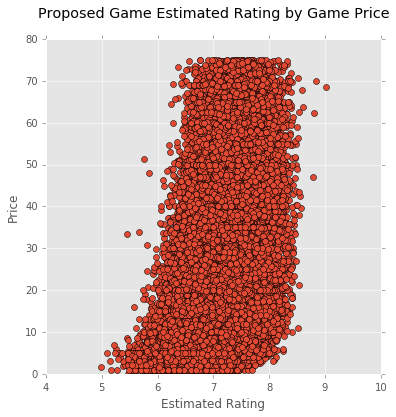

year                    2017.000000
weightAvg                  4.292468
weightLightPct             0.755805
weightMediumLightPct       0.003803
weightMediumPct            7.054309
weightMediumHeavyPct      53.609988
weightHeavyPct            38.576096
playerAgeMin              14.000000
playtimeMin               30.000000
playtimeMax               60.000000
playersStatedMin           2.000000
playersStatedMax           4.000000
playersBestMin             2.000000
playersBestMax             4.000000
priceAverage              68.640714
...
mechanic:Trading                      0.000000
mechanic:Trick-taking                 0.000000
mechanic:Variable Phase Order         0.000000
mechanic:Variable Player Powers       0.000000
mechanic:Voting                       0.000000
mechanic:Worker Placement             0.000000
subdomain:Abstract Strategy Games     0.399953
subdomain:Children's Games            0.009975
subdomain:Customizable Games         37.922998
subdomain:Family Games           

In [53]:
proposed_games['predicted_rating'] = predicted_ratings
proposed_games.sort(columns='predicted_rating', ascending=False)

# Let's limit our potential games to those under $75, and see how the ratings fall by price.
plt.figure(figsize=(6,6))
plt.plot(proposed_games.query("priceAverage < 75")['predicted_rating'],
         proposed_games.query("priceAverage < 75")['priceAverage'],
         'o')
plt.xlabel("Estimated Rating")
plt.ylabel("Price")
plt.title("Proposed Game Estimated Rating by Game Price", y=1.05)
plt.show()

best_game = proposed_games.query("priceAverage < 75").sort(columns='predicted_rating', ascending=False).iloc[0]
print(best_game)
print("")
print(best_game[filter(re.compile('^mechanic.*').match, feature_cols)])
print("")
print(best_game[filter(re.compile('^category.*').match, feature_cols)])


## Conclusion

1. I was able to produce a model that achieved a higher Pearson correlation when stacking learners than I was from any learner individually.

1. I was able to surpass the intended threshold of a model whose predictions correlate with those of humans at a value of 0.8 or better.

1. In attempting to train the model with more data, but two fewer features, the model produced fared worse than the original, leading me to the conclusion that the price features have power when predicting the rating of an individual board game.

## Illustrative Plots for the Paper

### Correlation Coefficients

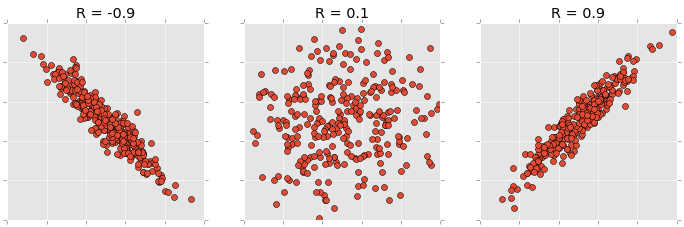

In [54]:
# Settings that apply to all plots
f, (neg, zero, pos) = plt.subplots(1, 3, figsize=(12, 4))
plots = [
    (neg,  [[.03, -.03], [.001, .001]]),  # Negative correlation
    (zero, [[.05, 0],    [0, .05]]),      # Random (near-zero) correlation
    (pos,  [[.03, .03],  [-.001, .001]])] # Positive correlation
for (subplot, covariance) in (plots):
    # Distributions centered around the midpoint between 0 and 1
    mean = [0.5, 0.5]
    x, y = np.random.multivariate_normal(mean, covariance, 300).T
    subplot.set_aspect('equal', adjustable='box')
    subplot.plot(x, y, 'o')
    subplot.set_xlim(0,1)
    subplot.set_ylim(0,1)
    subplot.axes.get_xaxis().set_ticklabels([])
    subplot.axes.get_yaxis().set_ticklabels([])
    subplot.set_title("R = {0:.1f}".format(pearsonr(x, y)[0]))
#Show them all
plt.show()

### Comparative Model Performance

In [104]:
# Provide meaningful column names
performance=performance.rename(columns={0:'Estimator',
                                        1:'Mean Squared Error',
                                        2:'Pearson Correlation'})
# Sort by correlation (ascending)
performance = performance.sort('Pearson Correlation')
print(performance)

                   Estimator  Mean Squared Error  Pearson Correlation
1        KNeighborsRegressor            0.535480             0.683170
2                        SVR            0.408617             0.769350
0      RandomForestRegressor            0.369920             0.794391
3  GradientBoostingRegressor            0.358262             0.800557
4          StackedRegression            0.344842             0.808837

[5 rows x 3 columns]


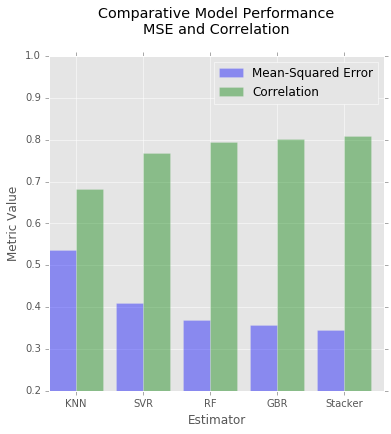

In [103]:
index = np.arange(5)
bar_width = 0.4
opacity = 0.4
plt.figure(figsize=(6,6))

bars1 = plt.bar(index, performance['Mean Squared Error'], bar_width,
                 alpha=opacity,
                 color='b',
                 label='Mean-Squared Error')

bars2 = plt.bar(index + bar_width, performance['Pearson Correlation'], bar_width,
                 alpha=opacity,
                 color='g',
                 label='Correlation')

plt.xlabel('Estimator')
plt.ylabel('Metric Value')
plt.title('Comparative Model Performance\nMSE and Correlation', y=1.05)
plt.ylim(0.2,1)
plt.xticks(index + bar_width, ('KNN', 'SVR', 'RF', 'GBR', 'Stacker'))
plt.legend()
plt.show()